## Salary Prediction

### Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as du
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import scipy.stats as st

### Read Data

In [2]:
salary_df = pd.read_csv('Salary_Data_Based_country_and_race.csv')
salary_df.head()

,Unnamed: 0,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Country,Race
0,0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0,UK,White
1,1,28.0,Female,Master's,Data Analyst,3.0,65000.0,USA,Hispanic
2,2,45.0,Male,PhD,Senior Manager,15.0,150000.0,Canada,White
3,3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0,USA,Hispanic
4,4,52.0,Male,Master's,Director,20.0,200000.0,USA,Asian


Get Some Statistics

In [3]:
salary_df.describe()

,Unnamed: 0,Age,Years of Experience,Salary
count,6704.000000,6702.000000,6701.000000,6699.000000
mean,3351.500000,33.620859,8.094687,115326.964771
std,1935.422435,7.614633,6.059003,52786.183911
min,0.000000,21.000000,0.000000,350.000000
25%,1675.750000,28.000000,3.000000,70000.000000
50%,3351.500000,32.000000,7.000000,115000.000000
75%,5027.250000,38.000000,12.000000,160000.000000
max,6703.000000,62.000000,34.000000,250000.000000


In [4]:
salary_df.describe(include='object')

,Gender,Education Level,Job Title,Country,Race
count,6702,6701,6702,6704,6704
unique,3,7,193,5,10
top,Male,Bachelor's Degree,Software Engineer,USA,White
freq,3674,2267,518,1360,1968


Find null values

In [5]:
salary_df.isnull().sum()

Unnamed: 0             0
Age                    2
Gender                 2
Education Level        3
Job Title              2
Years of Experience    3
Salary                 5
Country                0
Race                   0
dtype: int64

In [6]:
# Since there aren't many null values, I choose to drop all rows containing null value
salary_df.dropna(inplace=True)
salary_df.shape

(6698, 9)

Drop Not need Rows and Columns

In [7]:
# Drop duplicates if there is any
salary_df.drop_duplicates(inplace=True)

# We can drop the first row, since it's just the index
salary_df.drop(columns=['Unnamed: 0'], inplace=True)
print(salary_df.shape)

salary_df.head(5)

(6698, 8)


,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Country,Race
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0,UK,White
1,28.0,Female,Master's,Data Analyst,3.0,65000.0,USA,Hispanic
2,45.0,Male,PhD,Senior Manager,15.0,150000.0,Canada,White
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0,USA,Hispanic
4,52.0,Male,Master's,Director,20.0,200000.0,USA,Asian


### EDA

Age

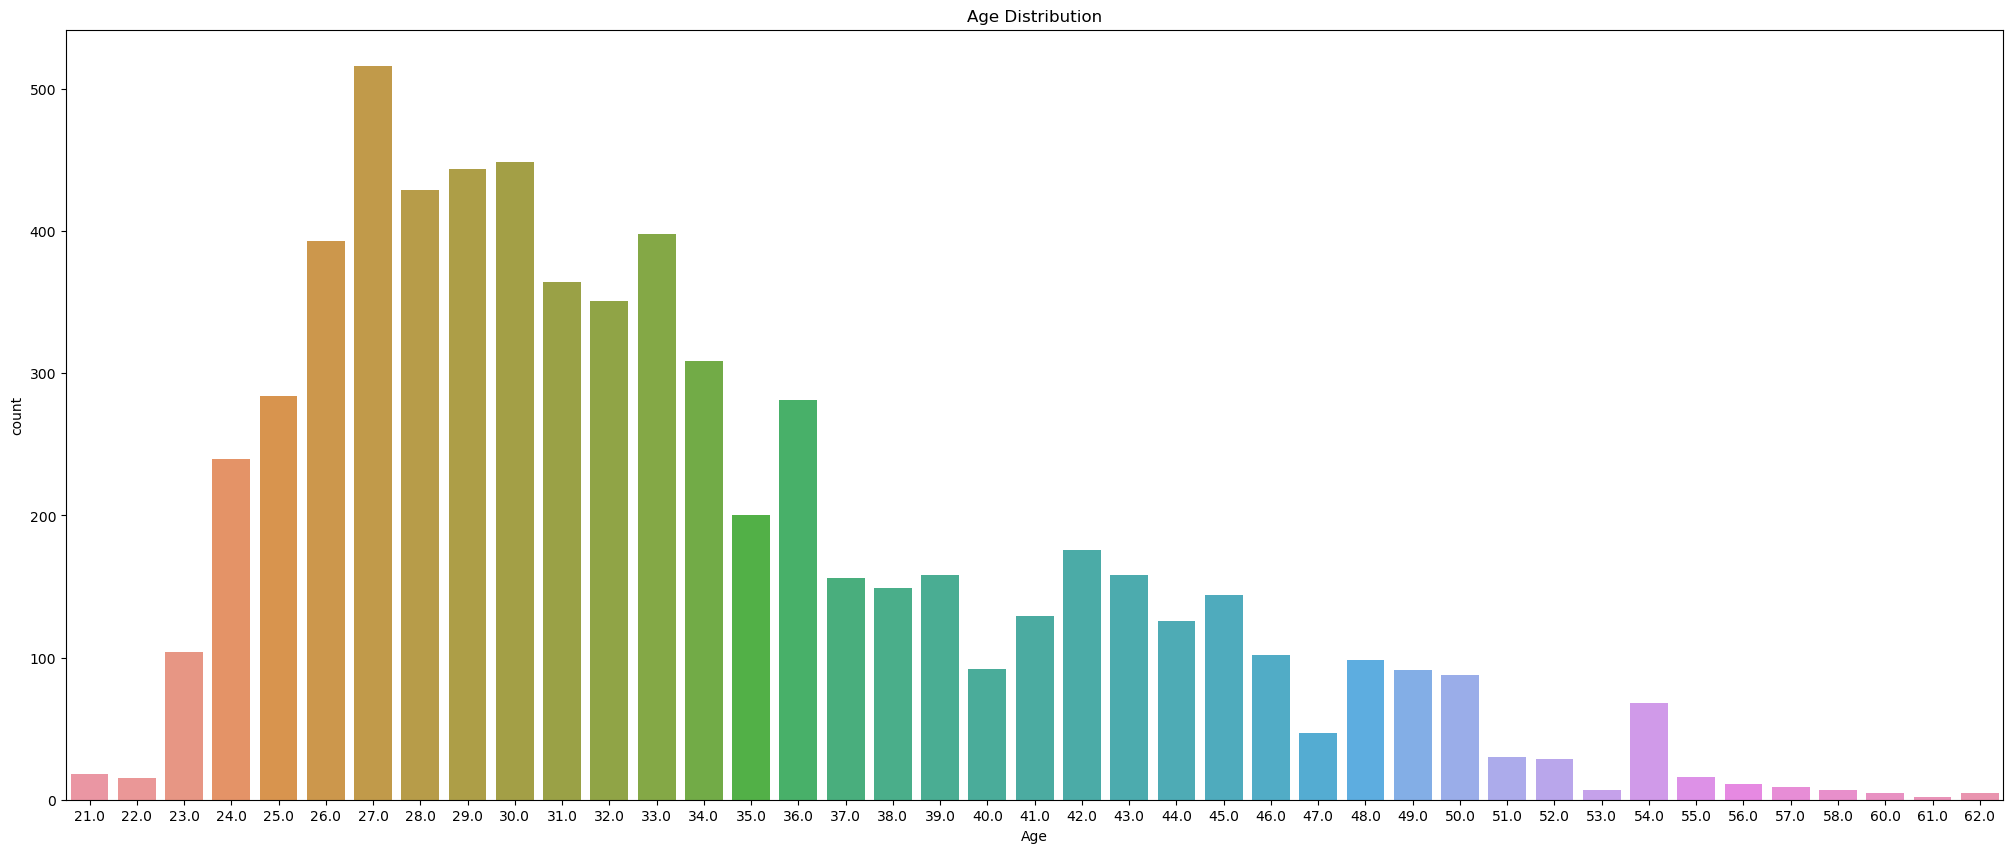

In [8]:
plt.figure(figsize=(25, 10))
plt.title('Age Distribution')
sns.countplot(data=salary_df, x='Age')
plt.show()

Gender

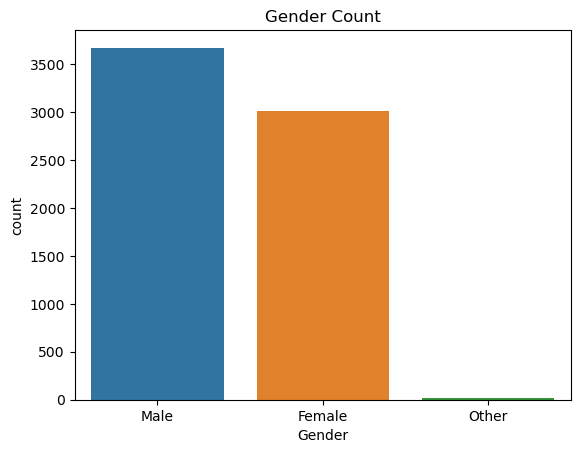

In [9]:
# gender_count = salary_df['Gender'].value_counts()

# plt.pie(x=gender_count, labels=gender_count.index, autopct='%1.1f%%', pctdistance=1.25, labeldistance=1.5)
# plt.show()

plt.title('Gender Count')
sns.countplot(data=salary_df, x='Gender')
plt.show()

Education Level

Bachelor's Degree    3021
Master's Degree      1860
PhD                  1369
High School           448
Name: Education Level, dtype: int64


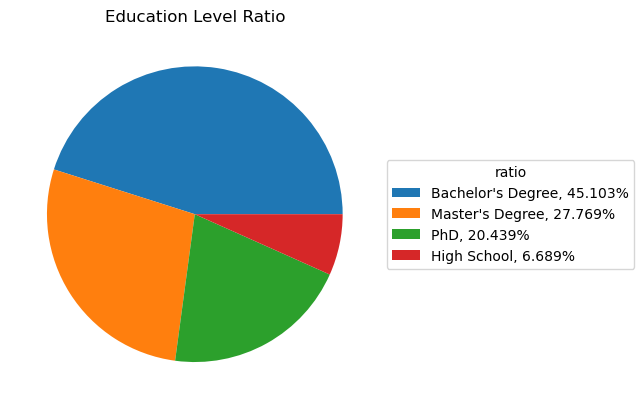

In [10]:
# I notice that Master's and Master's Degree are the same. PhD and phD are the same, so I combine them
salary_df['Education Level'].replace(to_replace=['phD', 'Master\'s', 'Bachelor\'s'], value=['PhD', 'Master\'s Degree', 'Bachelor\'s Degree'], inplace=True)

education_count = salary_df['Education Level'].value_counts()
print(education_count)

labels = education_count.index
labels = [f'{l}, {(s / sum(education_count)*100):.3f}%' for l, s in zip(labels, education_count)]

plt.title('Education Level Ratio')
plt.pie(x=education_count)
plt.legend(labels=labels,
           title="ratio",
           loc="center left",
           bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

Job Title

In [25]:
job_title_count = salary_df['Job Title'].value_counts()

replace = {'Software Developer': 'Software Engineer', 'Business Analyst': 'Data Analyst', \
           'Business Intelligence Analyst': 'Data Analyst', 'Developer': 'Software Developer', \
            }

print(job_title_count[job_title_count > 50])

Software Engineer                   518
Data Scientist                      453
Software Engineer Manager           376
Data Analyst                        363
Senior Project Engineer             318
Product Manager                     313
Full Stack Engineer                 308
Marketing Manager                   255
Back end Developer                  244
Senior Software Engineer            244
Front end Developer                 241
Marketing Coordinator               158
Junior Sales Associate              142
Financial Manager                   134
Marketing Analyst                   132
Software Developer                  125
Operations Manager                  114
Human Resources Manager             104
Director of Marketing                88
Web Developer                        87
Research Director                    75
Product Designer                     75
Content Marketing Manager            73
Sales Associate                      70
Senior Product Marketing Manager     69


Years of Experience

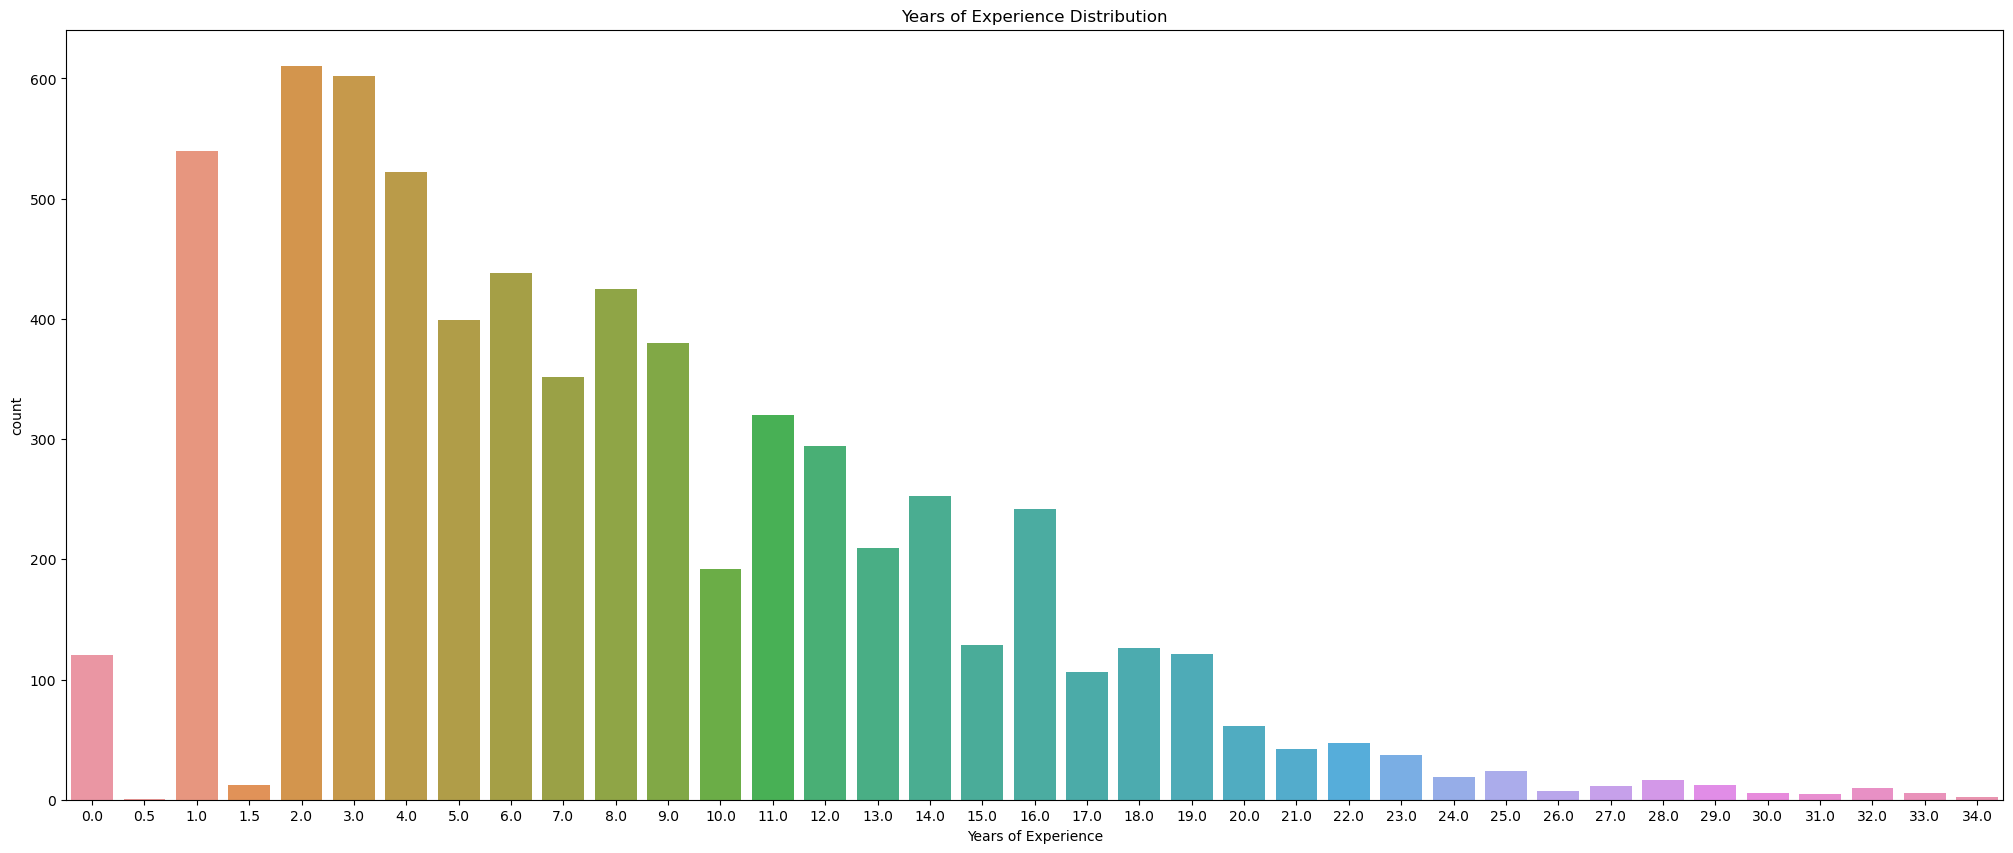

In [12]:
plt.figure(figsize=(25, 10))
plt.title('Years of Experience Distribution')
sns.countplot(data=salary_df, x='Years of Experience')
plt.show()

Salary

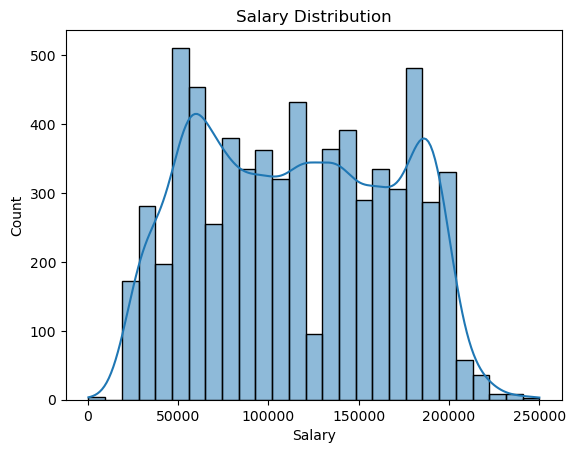

In [13]:
plt.title('Salary Distribution')
sns.histplot(data=salary_df, x='Salary', kde=True)
plt.show()

Country

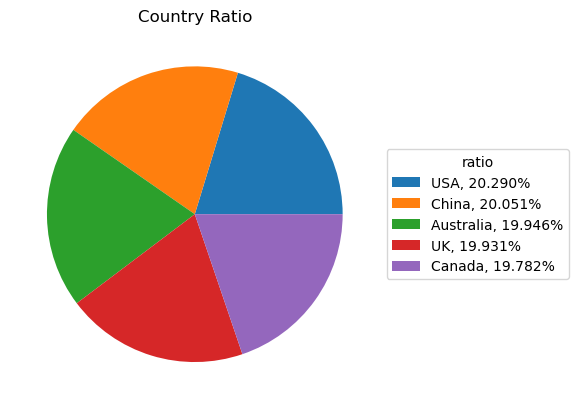

In [14]:
country_count = salary_df['Country'].value_counts()

labels = country_count.index
labels = [f'{l}, {(s / sum(country_count)*100):.3f}%' for l, s in zip(labels, country_count)]

plt.title('Country Ratio')
plt.pie(x=country_count)
plt.legend(labels=labels,
           title="ratio",
           loc="center left",
           bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

Race

White       2747
Asian       2504
Black        791
Mixed        334
Hispanic     322
Name: Race, dtype: int64


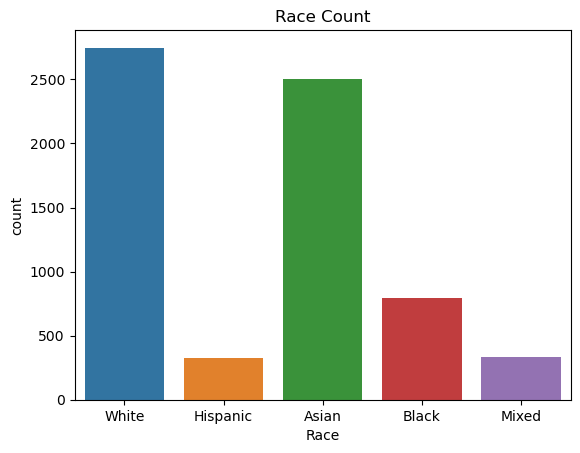

In [15]:
# Group related races togethter
replace = {'Chinese': 'Asian', 'Korean': 'Asian', 'African American': 'Black', 'Welsh': 'White', 'Australian': 'White'}
salary_df['Race'].replace(to_replace=replace, inplace=True)

race_count = salary_df['Race'].value_counts()
print(race_count)

plt.title('Race Count')
sns.countplot(data=salary_df, x='Race')
plt.show()

Correlation for Numeric Features

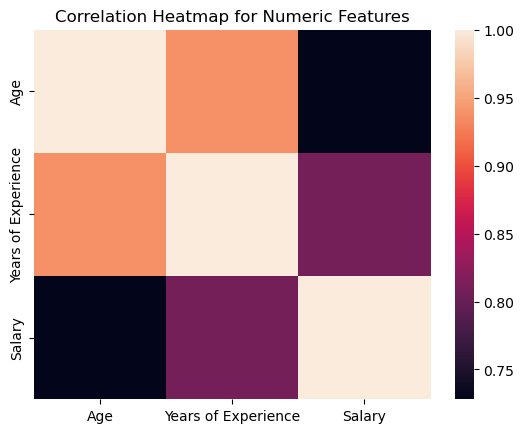

In [16]:
plt.title('Correlation Heatmap for Numeric Features')
corr = salary_df.corr(numeric_only=True)
sns.heatmap(corr)
plt.show()

Scatter Plot for Each Pair of Numeric Feature

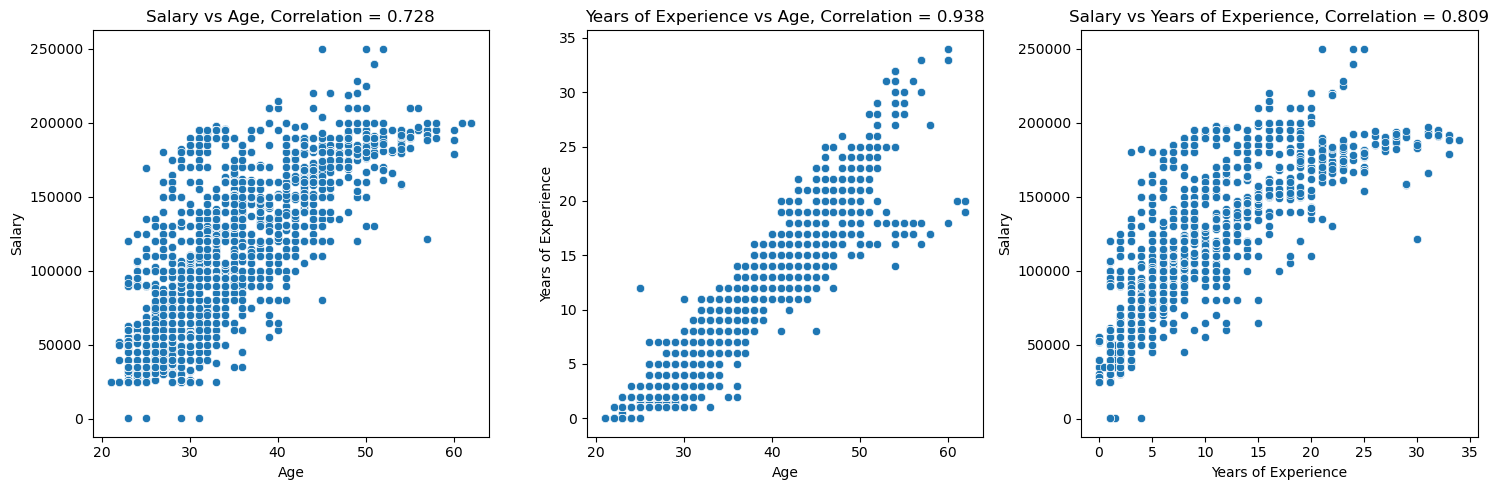

In [17]:
plt.figure(figsize=(15, 5), tight_layout=True)

plt.subplot(131)
plt.title('Salary vs Age, Correlation = {:.3f}'.format(corr['Salary']['Age']))
sns.scatterplot(data=salary_df, x='Age', y='Salary')

plt.subplot(132)
plt.title('Years of Experience vs Age, Correlation = {:.3f}'.format(corr['Years of Experience']['Age']))
sns.scatterplot(data=salary_df, x='Age', y='Years of Experience')

plt.subplot(133)
plt.title('Salary vs Years of Experience, Correlation = {:.3f}'.format(corr['Years of Experience']['Salary']))
sns.scatterplot(data=salary_df, x='Years of Experience', y='Salary')

plt.show()

Salary Distribution w.r.t Different Race, Gender, Education Level, Country

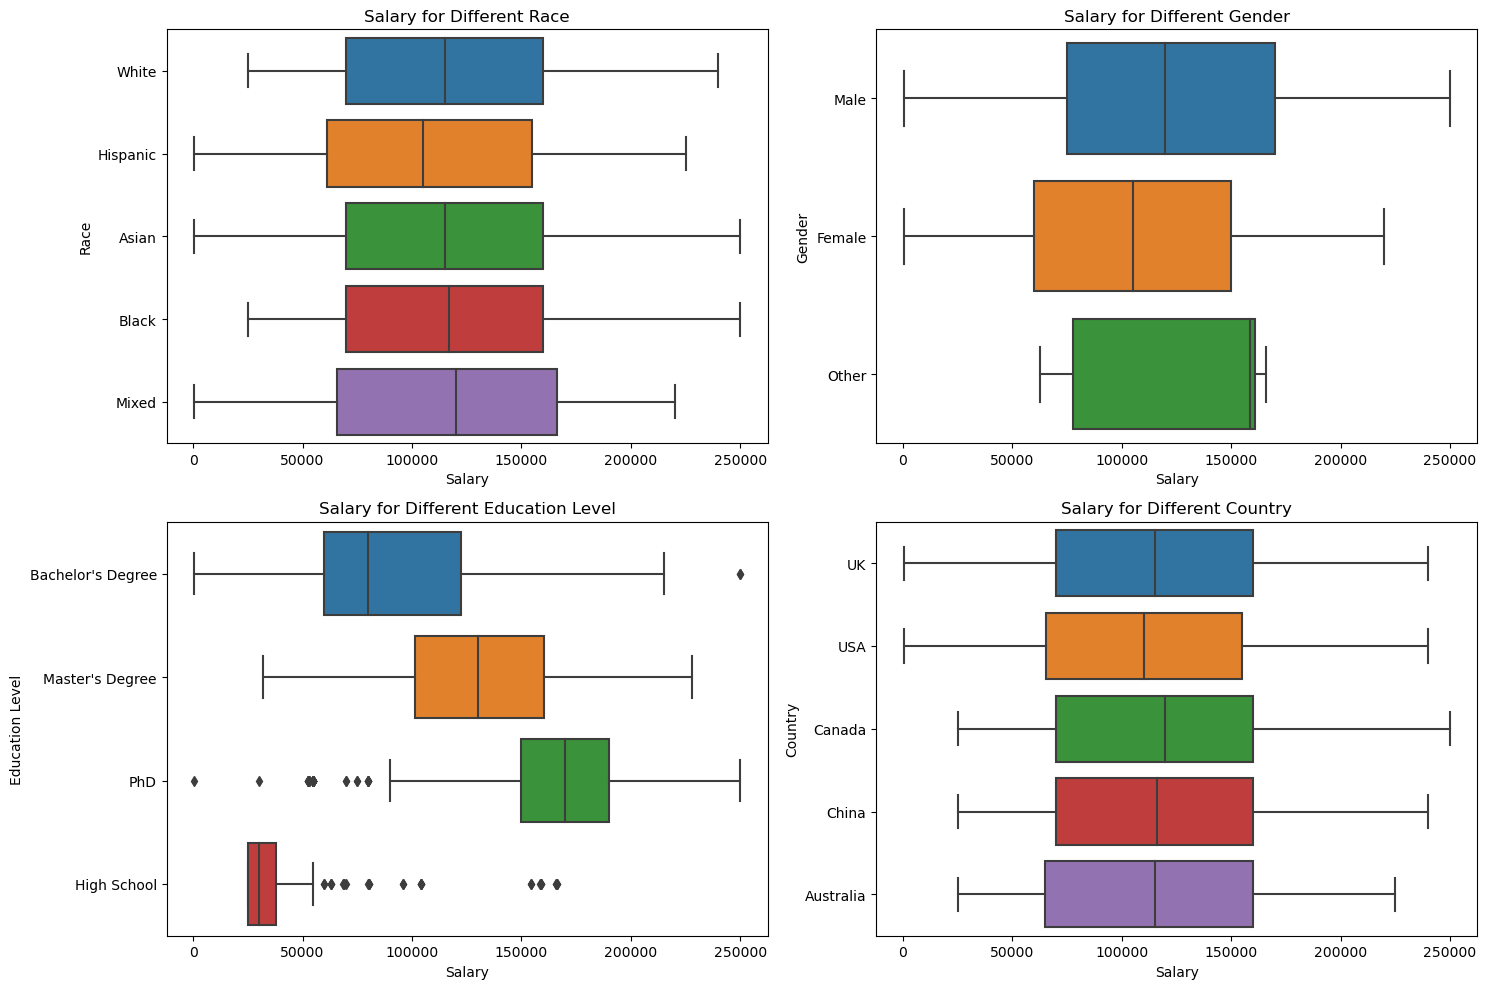

In [20]:
plt.figure(figsize=(15, 10), tight_layout=True)

plt.subplot(2,2,1)
plt.title('Salary for Different Race')
sns.boxplot(data=salary_df, x='Salary', y='Race')

plt.subplot(2,2,2)
plt.title('Salary for Different Gender')
sns.boxplot(data=salary_df, x='Salary', y='Gender')

plt.subplot(2,2,3)
plt.title('Salary for Different Education Level')
sns.boxplot(data=salary_df, x='Salary', y='Education Level')

plt.subplot(2,2,4)
plt.title('Salary for Different Country')
sns.boxplot(data=salary_df, x='Salary', y='Country')

plt.show()

We can observe that there is significant difference between salaries for different education level. There is some difference between salaries for different gender. Under different race, Hispanic's salary seems lower comparing to every other races. Under different country, the USA's salary seems lower comparing to every other countries.

Job Title

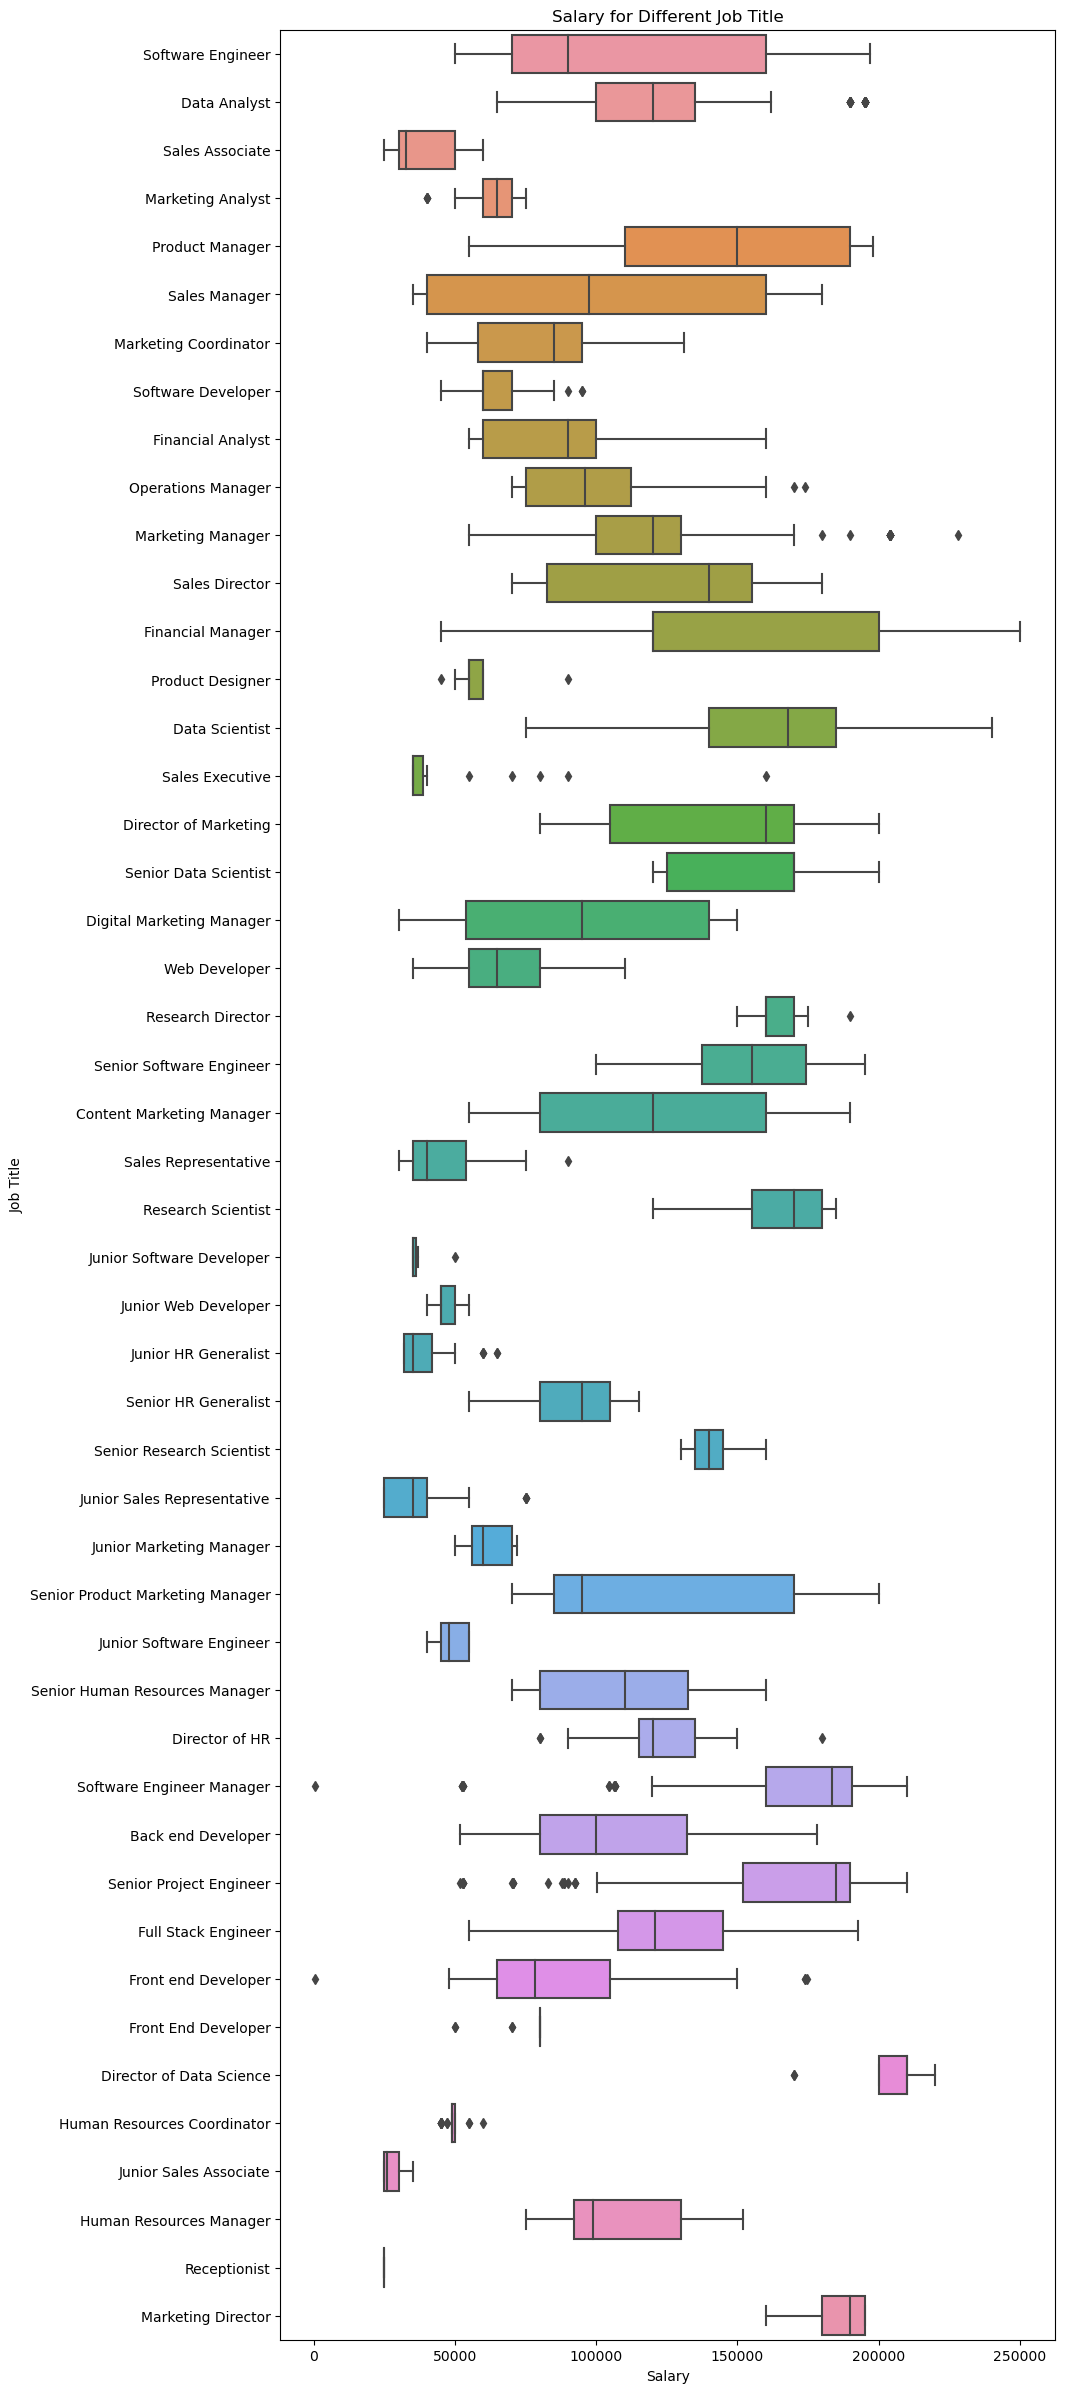

In [31]:
jobs = job_title_count[job_title_count > 30].index

salary_df_job = salary_df.loc[salary_df['Job Title'].isin(jobs)]

plt.figure(figsize=(10, 30))
plt.title('Salary for Different Job Title')
sns.boxplot(data=salary_df_job, x='Salary', y='Job Title')
plt.show()

We can observe that job title plays big role on salary. The salaries are relatively high for director or manager level role. Junior level roles have a relatively lower salary.